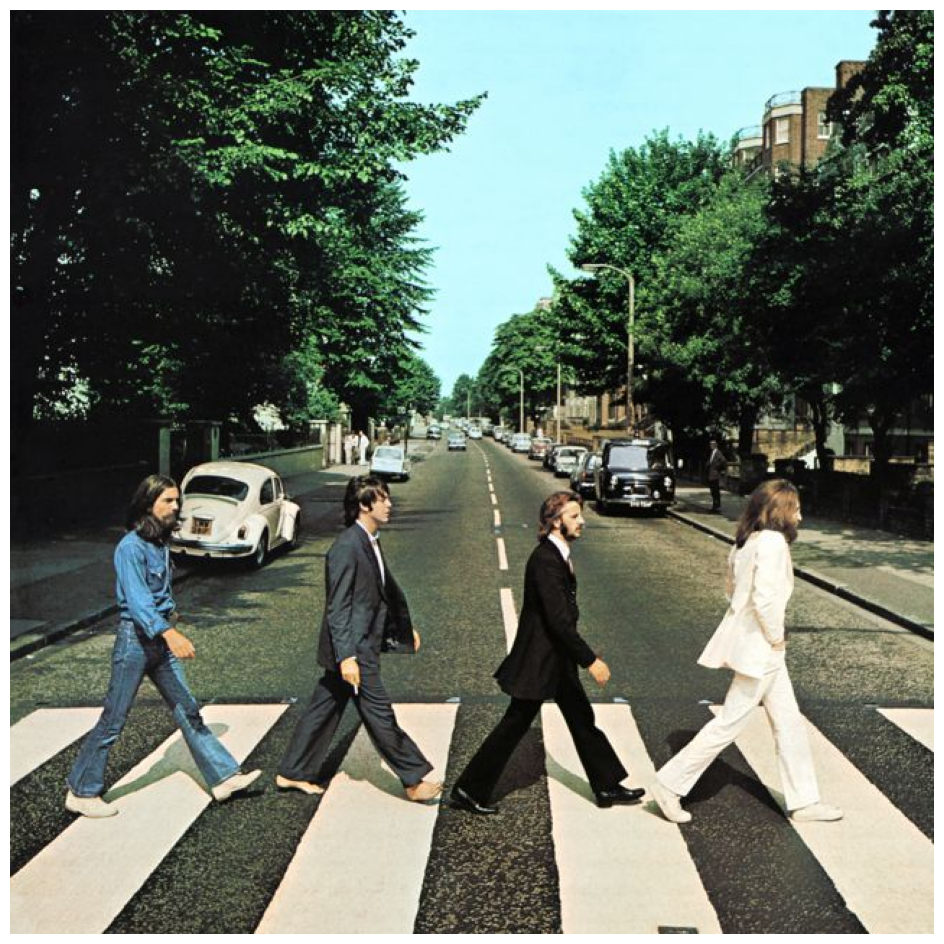

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy  as np
%matplotlib inline

img = cv2.imread('test_beatles.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(img_rgb)

In [12]:
cv_net = cv2.dnn.readNetFromTensorflow('./Instance_Segmentation_Model/pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb', 
                                     './Instance_Segmentation_Model/pretrained/mask_rcnn_inception_v2_coco_2018_01_28/graph.pbtxt')

blob = cv2.dnn.blobFromImage(img , swapRB=True, crop=False)
cv_net.setInput(blob)

# Bounding box 정보는 detection_out_final layer에서 mask 정보는 detection_masks layer에서 추출. 
boxes, masks = cv_net.forward(['detection_out_final', 'detection_masks'])

In [13]:
layer_names = cv_net.getLayerNames()
outlayer_names = [layer_names[i - 1] for i in cv_net.getUnconnectedOutLayers()]
print(type(layer_names),len(layer_names))
print(layer_names.index('detection_out_final'), layer_names.index('detection_masks'))

<class 'tuple'> 332
260 331


In [14]:
# coco dataset의 클래스 ID별 클래스명 매핑
labels_to_names_seq= {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}



#masking 시 클래스별 컬러 적용
colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250],
     [50, 190, 190]] )

In [15]:
print('boxes shape:', boxes.shape, 'masks shape:', masks.shape)
# 각각이 무슨 역할인지는 바로 다음 코드 참조
# 지금 100개의 객체를 찾았다. confidence를 이용해서 몇개 거르긴 해야 함

boxes shape: (1, 1, 100, 7) masks shape: (100, 90, 15, 15)


In [16]:
numClasses = masks.shape[1]
numDetections = boxes.shape[2]

# opencv의 rectangle(), putText() API는 인자로 들어온 IMAGE array에 그대로 수정작업을 수행하므로 bounding box 적용을 위한 
# 별도의 image array 생성. 
draw_img = img.copy()

img_height = draw_img.shape[0]
img_width = draw_img.shape[1]

conf_threshold = 0.5
mask_threshold = 0.3

green_color=(0, 255, 0)
red_color=(0, 0, 255)

# 이미지를 mask 설명을 위해서 iteration을 한번만 수행. 
#for i in range(numDetections):
for i in range(1):
    box = boxes[0, 0, i] # box변수의 7개 원소를 가져온다.
    mask = masks[i]      # 90, 15, 15 shaep의 list. 90 : 각 클래스에 대해서 분류 이미지 depth, 15 x 15를 해당 객체 box size로 확장해야함
    score = box[2]       # 아하 box변수의 3번째 원소가 score값
    if score > conf_threshold:
        classId = int(box[1])             
        left = int(img_width * box[3])  # 정규화 되어 있으니까, w,h랑 곱해주는거 잊지말기
        top = int(img_height * box[4])
        right = int(img_width * box[5])
        bottom = int(img_height * box[6])
        
        # 이미지에 bounding box 그림 그리기
        text = "{}: {:.4f}".format(labels_to_names_seq[classId], score)
        cv2.rectangle(draw_img, (left, top), (right, bottom), green_color, thickness=2 )
        cv2.putText(draw_img, text, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.3, red_color, 1)

        # mask 정보 처리하기
        classMask = mask[classId] # (15, 15)
        # 15 x 15 를 해당 객체 box size로 확장해야함
        scaled_classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1)) # (123, 224)
        # 지정된 mask Threshold 값 이상인지 True, False boolean형태의 mask 정보 생성. 
        s_mask_b = (scaled_classMask > mask_threshold) # bool형태의 (123, 224) 리스트 생성
        print('scaled mask shape:', s_mask_b.shape, '\nscaled mask pixel count:', s_mask_b.shape[0]*s_mask_b.shape[1],
              '\nscaled mask true shape:',s_mask_b[s_mask_b==True].shape, 
              '\nscaled mask False shape:', s_mask_b[s_mask_b==False].shape)
        # 원본 이미지의 bounding box 영역만 image 추출
        # 참고로 copy()해서 가져온게 아니기 때문에, before_mask_roi를 바꾸면 draw_img도 바뀐다
        before_mask_roi = draw_img[top:bottom+1, left:right+1]
        print('before_mask_roi:', before_mask_roi.shape)

scaled mask shape: (241, 131) 
scaled mask pixel count: 31571 
scaled mask true shape: (11816,) 
scaled mask False shape: (19755,)
before_mask_roi: (241, 131, 3)


In [17]:
vis_mask = (s_mask_b * 255).astype("uint8")  # true자리는 255로 만들어 준다

# mask정보를 덮어주는 작업을, cv2.bitwise_and 모듈을 사용해서 쉽게 한다.
# 객체가 있는 true자리만 그대로 놔두고, 아니면 검은색으로 바꿔버린다. vis_mask의 255가 검은색이다.
instance = cv2.bitwise_and(before_mask_roi, before_mask_roi, mask=vis_mask)

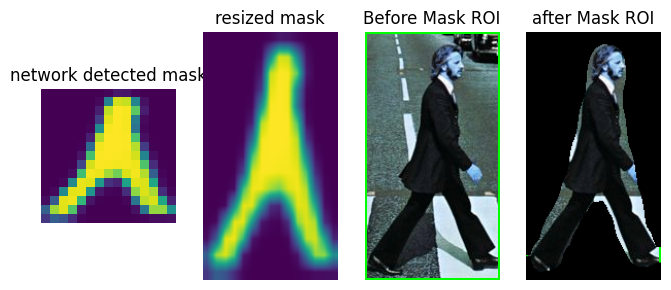

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(8, 8), ncols=4, nrows=1)

ax1.set_title('network detected mask')
ax1.axis('off')
ax1.imshow(classMask)

ax2.set_title('resized mask')
ax2.axis('off')
ax2.imshow(scaled_classMask)


ax3.set_title('Before Mask ROI')
ax3.axis('off')
ax3.imshow(before_mask_roi)

ax4.set_title('after Mask ROI')
ax4.axis('off')
ax4.imshow(instance)

(11816, 3)


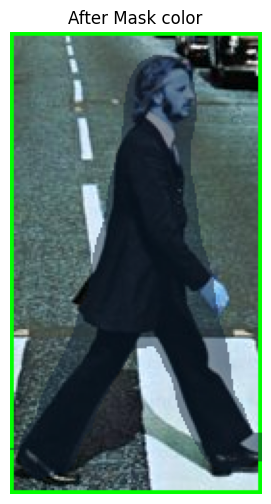

In [19]:
# 색갈을 하나 랜덤하게 골라서
colorIndex = np.random.randint(0, len(colors)-1)
color = colors[colorIndex]
after_mask_roi = draw_img[top:bottom+1, left:right+1][s_mask_b] # 필요한 부분만 때온다. 주의!! 2차원이 1차원으로 바뀐다! (depth정보는 그대로)
print(after_mask_roi.shape) 
# 이 코드를 계속 실행하면, 색을 덮고덮고덮고덮고를 반복한다. 랜덤으로 색이 바뀌는게 아니라...
draw_img[top:bottom+1, left:right+1][s_mask_b] = ([0.1*color[0], 0.1*color[1], 0.1*color[2]] + (0.5 * after_mask_roi)).astype(np.uint8)
# 2차원이든 1차원이든 쨋든 원하는 부분만 색을 바꿔준다. 투명 윈리는 위와 같다.

plt.figure(figsize=(6,6))
plt.axis('off')
plt.title('After Mask color')
plt.imshow(draw_img[top:bottom+1, left:right+1])
# 시각화 되는 건 draw_img의 일부분이지만, python variable immutable 때문에 draw_img의 전체도 바뀌어 있다

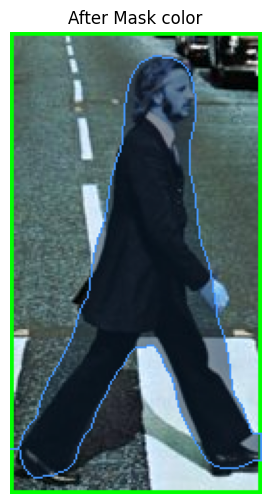

In [20]:
s_mask_i = s_mask_b.astype(np.uint8)
# https://datascienceschool.net/view-notebook/f9f8983941254a34bf0fee42c66c5539/ 에 이미지 컨투어 설명 있음 
contours, hierarchy = cv2.findContours(s_mask_i,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(draw_img[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 100)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.title('After Mask color')
plt.imshow(draw_img[top:bottom+1, left:right+1])

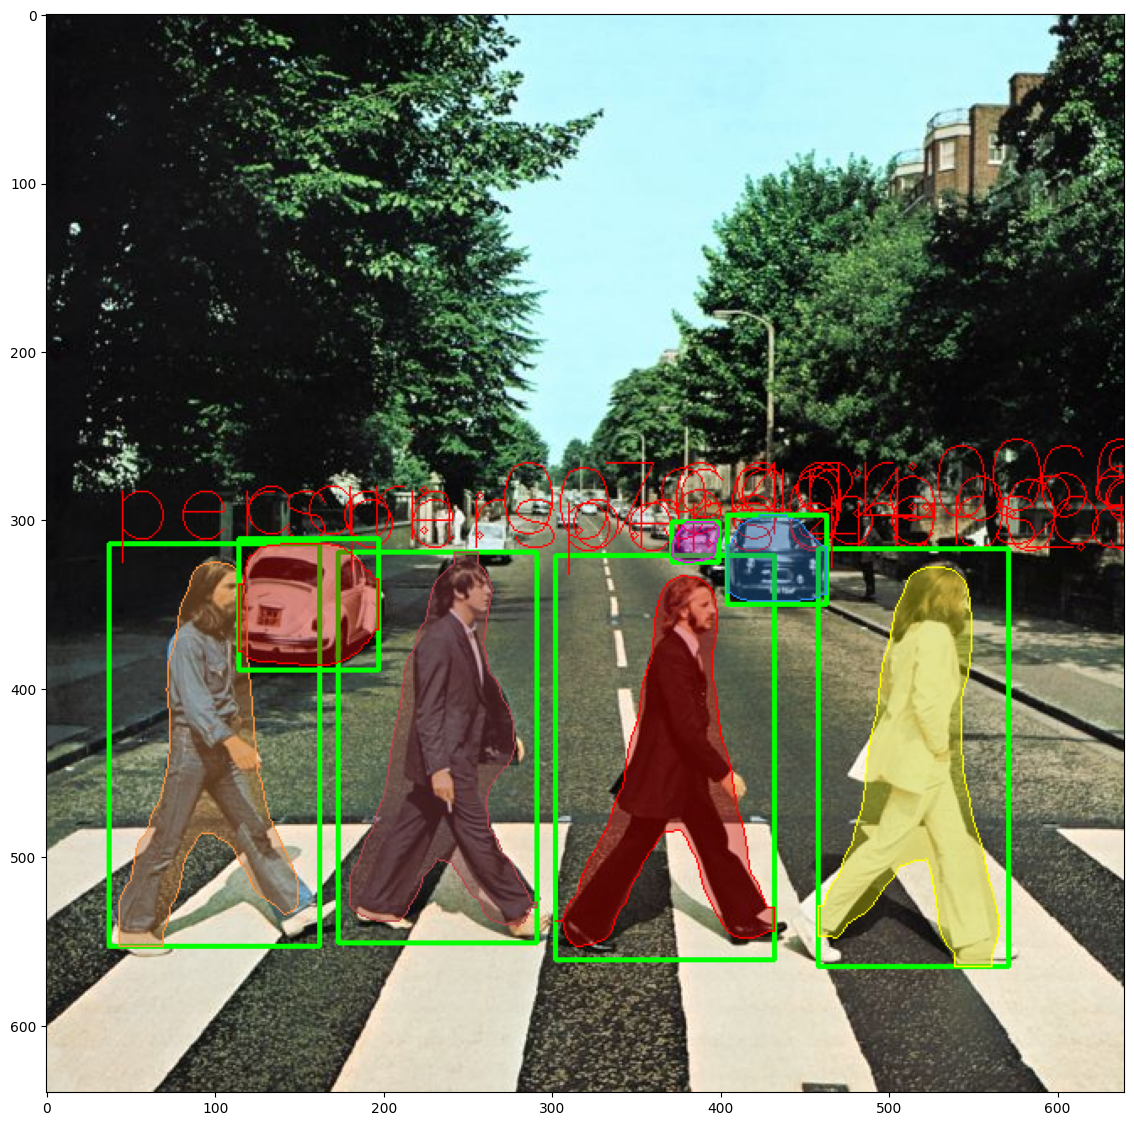

In [21]:
numClasses = masks.shape[1]
numDetections = boxes.shape[2]

# opencv의 rectangle(), putText() API는 인자로 들어온 IMAGE array에 그대로 수정작업을 수행하므로 bounding box 적용을 위한 
# 별도의 image array 생성. 
draw_img = img.copy()

img_height = draw_img.shape[0]
img_width = draw_img.shape[1]
conf_threshold = 0.5
mask_threshold = 0.3

green_color=(0, 255, 0)
red_color=(0, 0, 255)

for i in range(numDetections):
    box = boxes[0, 0, i]
    mask = masks[i]
    score = box[2]
    if score > conf_threshold:
        classId = int(box[1])
        left = int(img_width * box[3])
        top = int(img_height * box[4])
        right = int(img_width * box[5])
        bottom = int(img_height * box[6])

        text = "{}: {:.4f}".format(labels_to_names_seq[classId], score)
        cv2.rectangle(draw_img, (left, top), (right, bottom), green_color, thickness=2 )
        cv2.putText(draw_img, text, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 2, red_color, 1)

        classMask = mask[classId]
        scaled_classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
        s_mask_b = (scaled_classMask > mask_threshold)
        
        # 마스크 정보 투명하게 색 덮어 주기
        before_mask_roi = draw_img[top:bottom+1, left:right+1]
        colorIndex = np.random.randint(0, len(colors)-1)
        color = colors[colorIndex]
        after_mask_roi = draw_img[top:bottom+1, left:right+1][s_mask_b]
        draw_img[top:bottom+1, left:right+1][s_mask_b] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * after_mask_roi).astype(np.uint8)
        
        # Detect된 Object에 윤곽선(contour) 적용. 
        s_mask_i = s_mask_b.astype(np.uint8)
        contours, hierarchy = cv2.findContours(s_mask_i,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(draw_img[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 100)

plt.figure(figsize=(14, 14))
img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [22]:
def get_box_info(box, img_width, img_height):
    
    classId = int(box[1])
    left = int(img_width * box[3])
    top = int(img_height * box[4])
    right = int(img_width * box[5])
    bottom = int(img_height * box[6])
    
    left = max(0, min(left, img_width - 1))
    top = max(0, min(top, img_height - 1))
    right = max(0, min(right, img_width - 1))
    bottom = max(0, min(bottom, img_height - 1))
    
    return classId, left, top, right, bottom

    
def draw_box(img_array, box, img_width, img_height, is_print=False):
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    
    score = box[2]
    classId, left, top, right, bottom = get_box_info(box, img_width, img_height)
    text = "{}: {:.4f}".format(labels_to_names_seq[classId], score)
    
    if is_print:
        print("box:", box, "score:", score, "classId:", classId)
    
    cv2.rectangle(img_array, (left, top), (right, bottom), green_color, thickness=2 )
    cv2.putText(img_array, text, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, thickness=1)
    
    return img_array
    
def draw_mask(img_array, box, mask, img_width, img_height, mask_threshold, is_print=False):
        
        classId, left, top, right, bottom = get_box_info(box, img_width, img_height)
        classMask = mask[classId]
        
        # 원본 이미지의 object 크기에 맞춰 mask 크기 scale out 
        scaled_classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
        s_mask_b = (scaled_classMask > mask_threshold)
        before_mask_roi = img_array[top:bottom+1, left:right+1]
        
        # mask를 적용할 bounding box 영역의 image 추출하고 투명 color 적용. 
        colorIndex = np.random.randint(0, len(colors)-1)
        color = colors[colorIndex]
        after_mask_roi = img_array[top:bottom+1, left:right+1][s_mask_b]
        img_array[top:bottom+1, left:right+1][s_mask_b] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * after_mask_roi).astype(np.uint8)
        
        # Detect된 Object에 윤곽선(contour) 적용. 
        s_mask_i = s_mask_b.astype(np.uint8)
        contours, hierarchy = cv2.findContours(s_mask_i,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img_array[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 100)
        
        return img_array

In [23]:
import time

def detect_image_mask_rcnn(cv_net, img_array, conf_threshold, mask_threshold, use_copied_array, is_print=False):
    
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
        #draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    else:
        draw_img = img_array
        
    start_time = time.time()
    
    blob = cv2.dnn.blobFromImage(img_array, swapRB=True, crop=False)
    cv_net.setInput(blob)
    boxes, masks = cv_net.forward(['detection_out_final', 'detection_masks'])
    
    inference_time = time.time() - start_time
    if is_print:
        print('Segmentation Inference time {0:}'.format(inference_time))

    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    img_height = img_array.shape[0]
    img_width = img_array.shape[1]
    
    for i in range(numDetections):
        box = boxes[0, 0, i]
        mask = masks[i]
        score = box[2]
        #print("score:", score)
        if score > conf_threshold:
            draw_box(img_array , box, img_width, img_height, is_print=is_print)
            draw_mask(img_array, box, mask, img_width, img_height, mask_threshold, is_print=is_print)
    
    return img_array

Segmentation Inference time 0.5662143230438232
box: [0.         0.         0.99285626 0.4730245  0.50264657 0.6757933
 0.8768457 ] score: 0.99285626 classId: 0
box: [0.         0.         0.99278533 0.27107757 0.4991831  0.45520425
 0.86144114] score: 0.99278533 classId: 0
box: [0.         0.         0.9693933  0.05888663 0.49064893 0.25351197
 0.8655632 ] score: 0.9693933 classId: 0
box: [0.        0.        0.8691279 0.7168315 0.4963619 0.8935446 0.8832188] score: 0.8691279 classId: 0
box: [0.         2.         0.76422936 0.178418   0.48733777 0.30909693
 0.6081398 ] score: 0.76422936 classId: 2
box: [0.         2.         0.684392   0.5809506  0.47148904 0.623883
 0.509167  ] score: 0.684392 classId: 2
box: [0.         2.         0.63229996 0.63147223 0.46428317 0.7247541
 0.5473518 ] score: 0.63229996 classId: 2


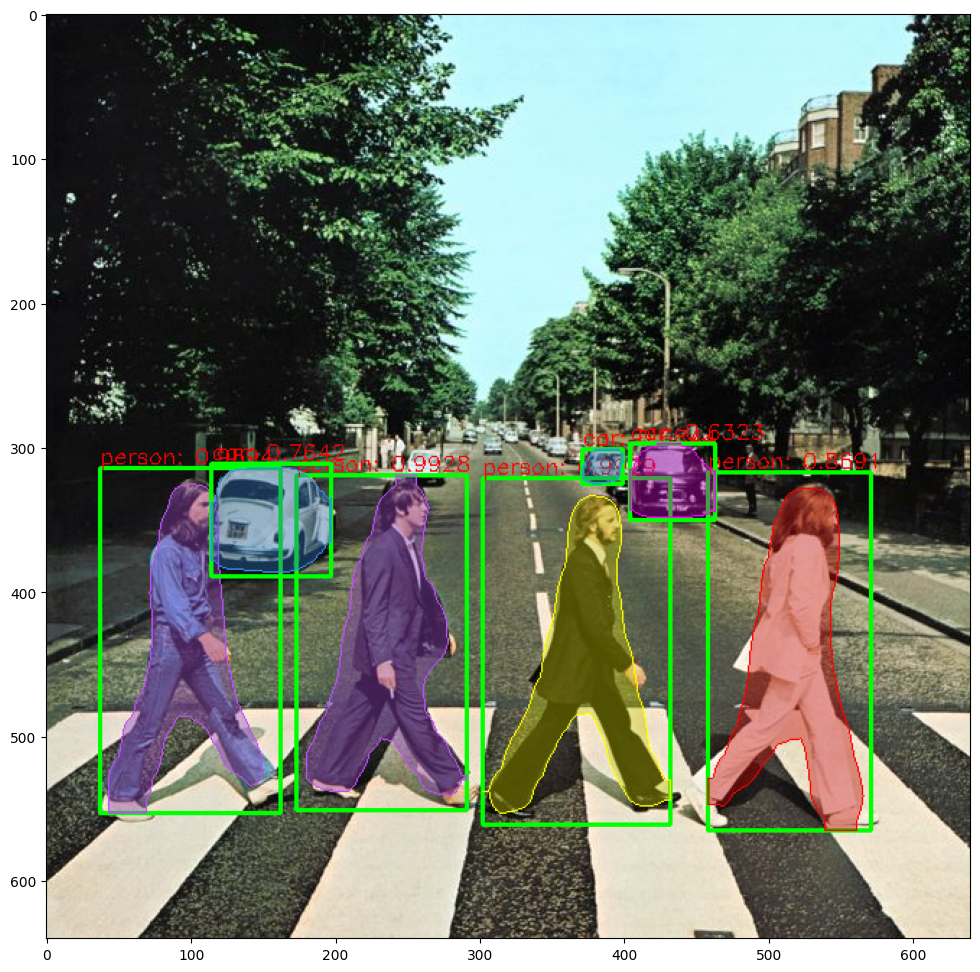

In [25]:
img = cv2.imread('test_beatles.jpg')

cv_net = cv2.dnn.readNetFromTensorflow('./Instance_Segmentation_Model/pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb', 
                                     './Instance_Segmentation_Model/pretrained/mask_rcnn_inception_v2_coco_2018_01_28/graph.pbtxt')

img_detected = detect_image_mask_rcnn(cv_net, img, conf_threshold=0.5, mask_threshold=0.3, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

Segmentation Inference time 0.4953792095184326
box: [0.         0.         0.99285626 0.4730245  0.50264657 0.6757933
 0.8768457 ] score: 0.99285626 classId: 0
box: [0.         0.         0.99278533 0.27107757 0.4991831  0.45520425
 0.86144114] score: 0.99278533 classId: 0
box: [0.         0.         0.9693933  0.05888663 0.49064893 0.25351197
 0.8655632 ] score: 0.9693933 classId: 0
box: [0.        0.        0.8691279 0.7168315 0.4963619 0.8935446 0.8832188] score: 0.8691279 classId: 0
box: [0.         2.         0.76422936 0.178418   0.48733777 0.30909693
 0.6081398 ] score: 0.76422936 classId: 2
box: [0.         2.         0.684392   0.5809506  0.47148904 0.623883
 0.509167  ] score: 0.684392 classId: 2
box: [0.         2.         0.63229996 0.63147223 0.46428317 0.7247541
 0.5473518 ] score: 0.63229996 classId: 2


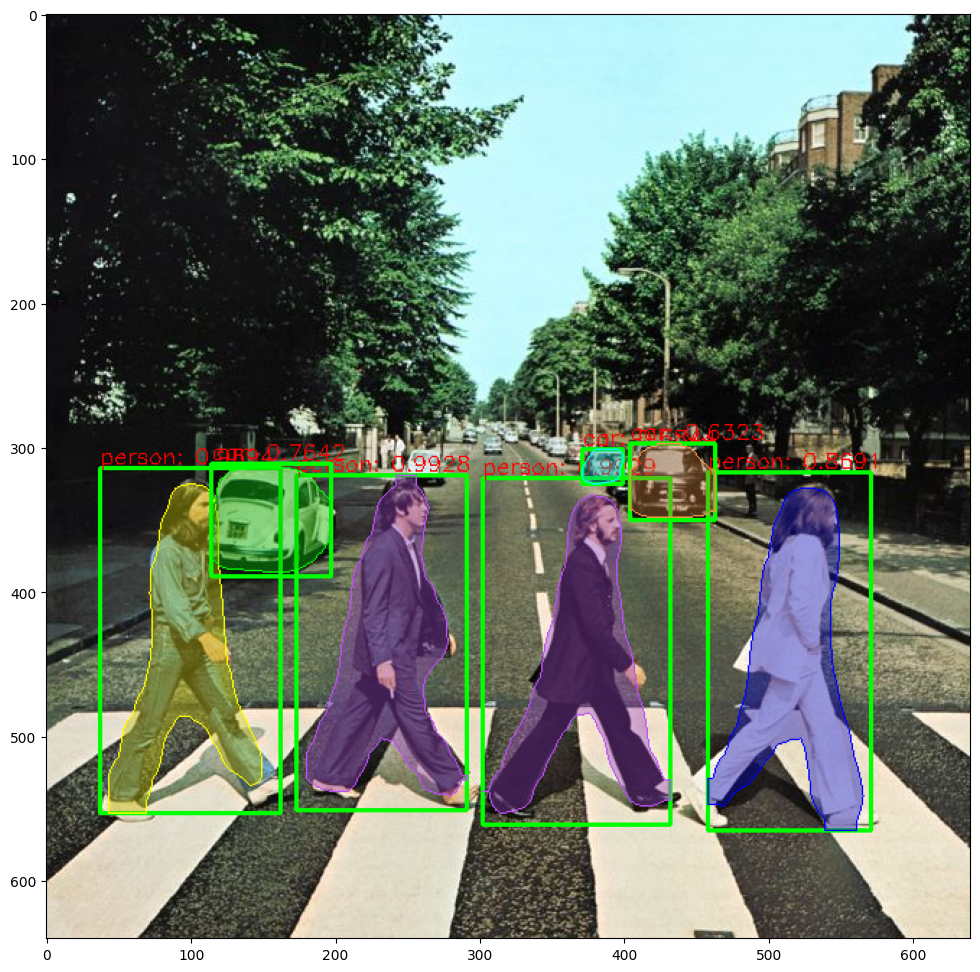

In [26]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

wick_img = cv2.imread('test_beatles.jpg')

wick_img_detected = detect_image_mask_rcnn(cv_net, wick_img, conf_threshold=0.5, mask_threshold=0.3, use_copied_array=True, is_print=True)

wick_img_rgb = cv2.cvtColor(wick_img_detected, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(wick_img_rgb)